# FPCA Clustering

In [1]:
import pandas as pd
import os
import glob
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from skfda.representation.grid import FDataGrid


import skfda
from skfda.datasets import fetch_growth
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,
)


from __future__ import annotations

from typing import Any, Mapping, Tuple

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import sklearn.cluster
from cartopy.io.img_tiles import GoogleTiles
from matplotlib.axes import Axes
from matplotlib.figure import Figure

from skfda.datasets import fetch_aemet
from skfda.exploratory.depth import ModifiedBandDepth
from skfda.exploratory.visualization import Boxplot, MagnitudeShapePlot
from skfda.exploratory.visualization.fpca import FPCAPlot
from skfda.misc.metrics import l2_distance
from skfda.ml.clustering import KMeans
from skfda.preprocessing.dim_reduction import FPCA

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Load Data for One Subject, One Frequency

In [2]:
#read each csv file in current_directory and store it in dataframes

current_directory = os.getcwd()
csv_files = glob.glob(os.path.join(current_directory, 'ABR_exported_files/*.csv'))

dataframes = {}
for file in csv_files:
    filename = os.path.splitext(os.path.basename(file))[0]
    if pd.read_csv(file).shape[1] > 1:
        dataframes[filename] = pd.read_csv(file)
    else:
        dataframes[filename] = pd.read_csv(file, skiprows=2)

In [55]:
# SELECT SUBJECT AND FREQUENCY #

######################
subject = 279
frequency = 8000
######################
waves = []
filename = list(dataframes.items())[subject][0]
df = list(dataframes.values())[subject]

for khz_value in [frequency]:
    for dbkhz_value in range(0, 95, 5):
        khz = df[df['Freq(Hz)'] == khz_value]
        dbkhz = khz[khz['Level(dB)'] == dbkhz_value]
        if not dbkhz.empty:
            index = dbkhz.index.values[0]
            final = df.loc[index,'0':]
            final = pd.to_numeric(final, errors='coerce')
            waves.append(final.tolist())
waves = [wave[:-1] for wave in waves]

# PLOT WAVES

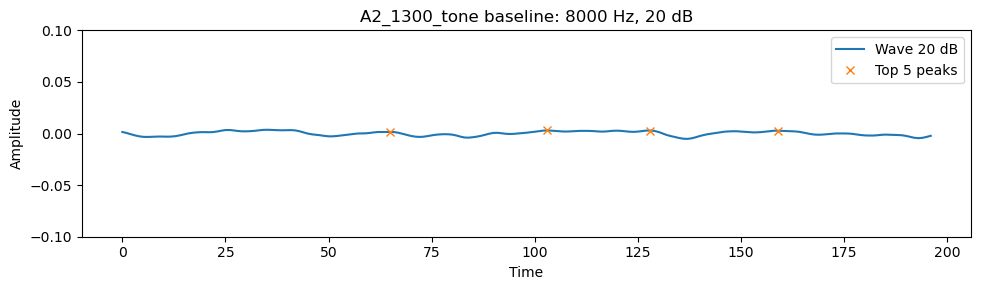

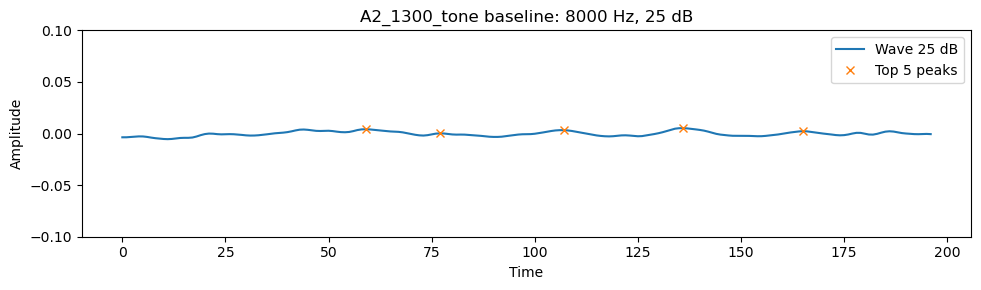

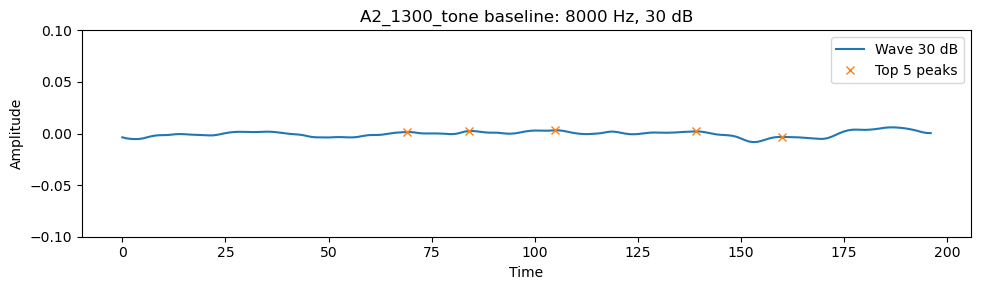

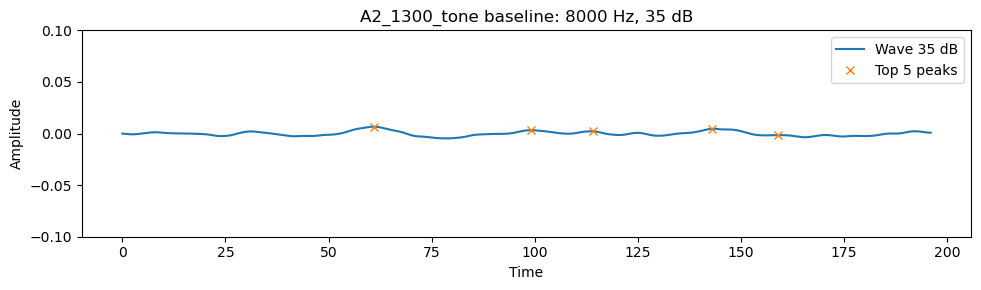

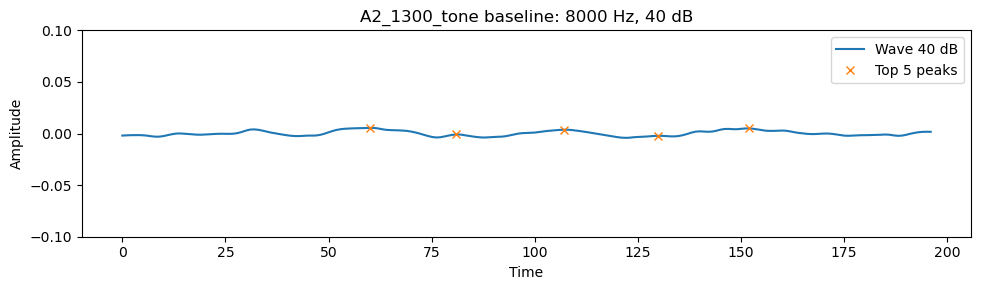

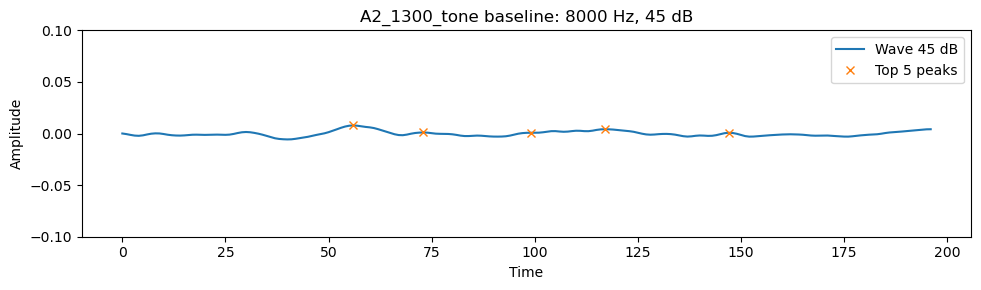

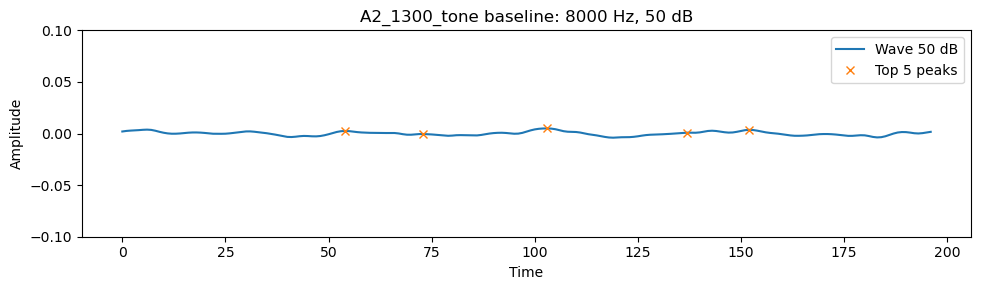

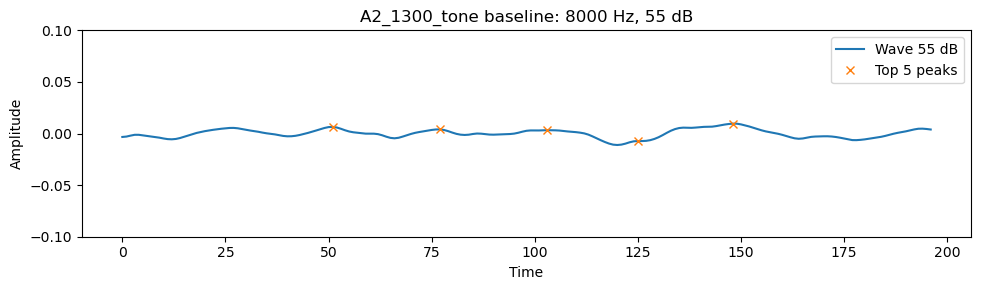

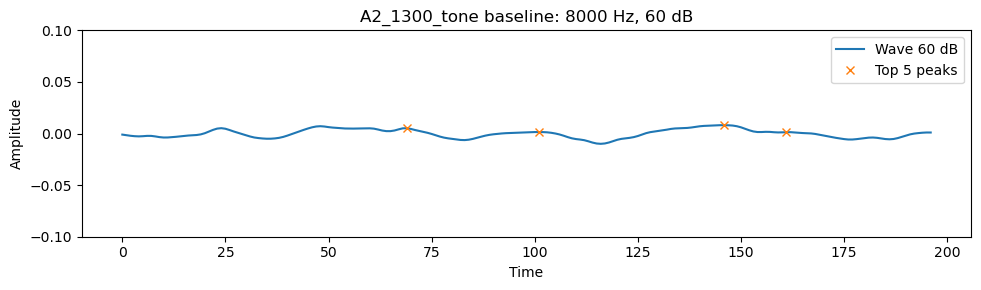

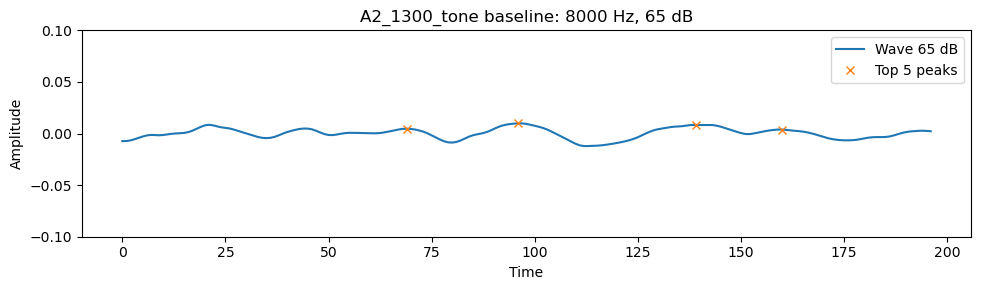

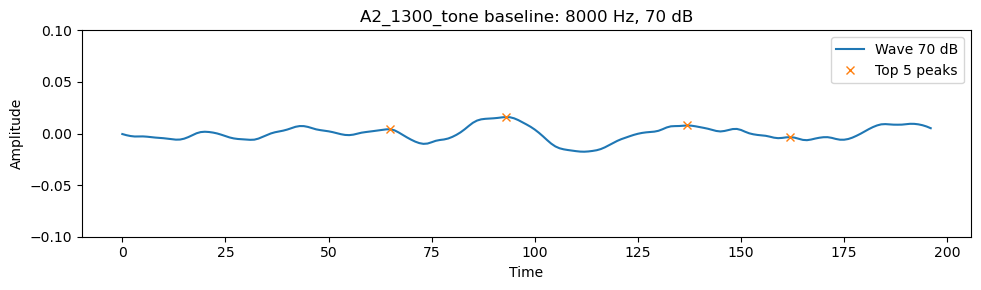

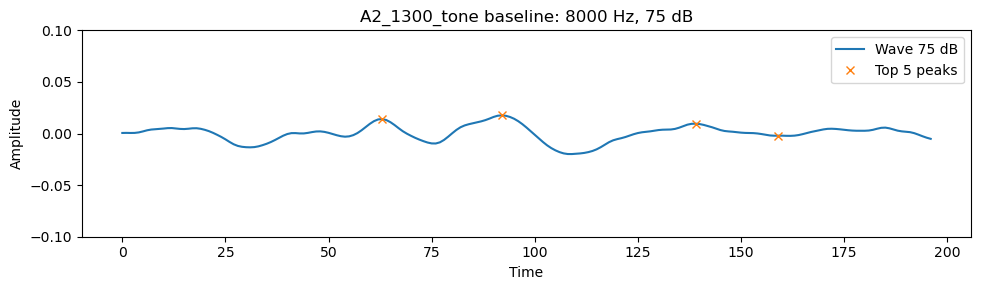

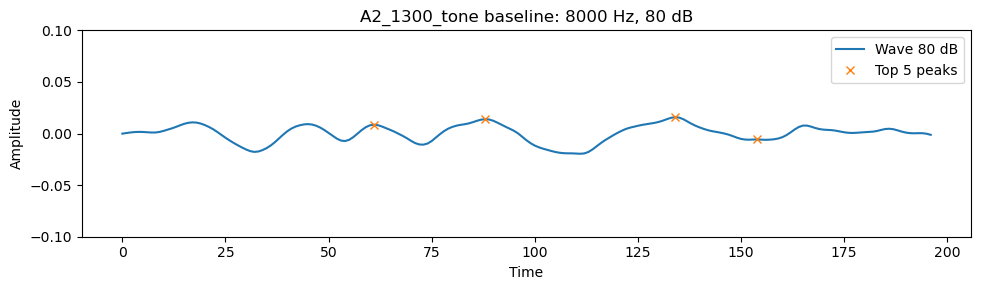

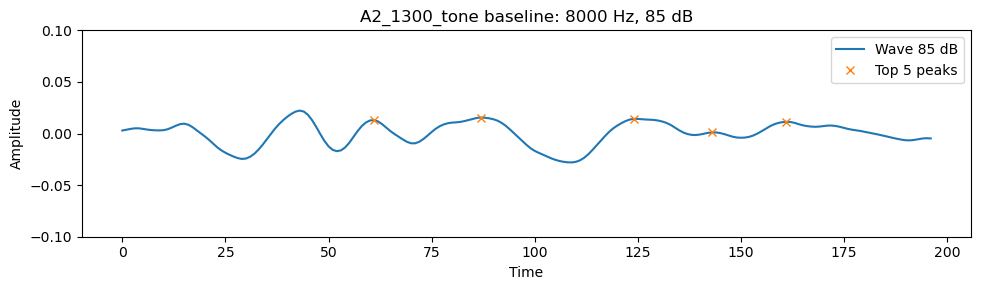

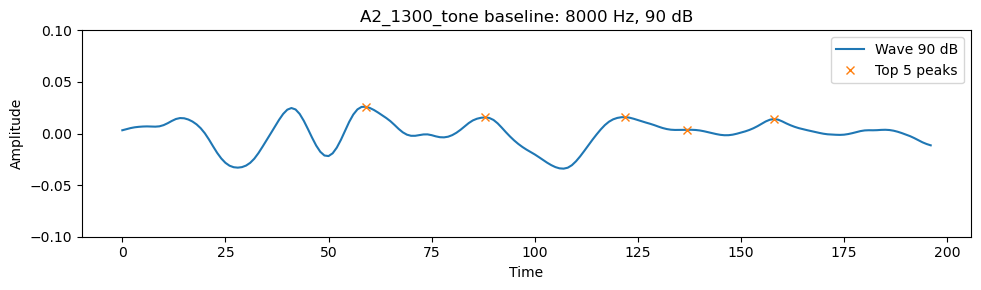

In [56]:
peaks_list = []
db_values = []
freq_values = []

for khz_value in [frequency]:
    for dbkhz_value in range(0, 95, 5):
        khz = df[df['Freq(Hz)'] == khz_value]
        dbkhz = khz[khz['Level(dB)'] == dbkhz_value]
        if not dbkhz.empty:
            index = dbkhz.index.values[0]
            final = df.iloc[index,48:]
            final = pd.to_numeric(final, errors='coerce')
            wave = final.tolist()[:-1]
            wave_after_30 = wave[50:-30]  # start from the 30th point and end before the last 30 points
            peaks, _ = find_peaks(wave_after_30, distance=15)
            peaks = [peak + 50 for peak in peaks]  # adjust the indices
            highest_peaks_indices = sorted(peaks, key=lambda x: wave[x], reverse=True)[:5]
            highest_peaks_indices.sort()
            peak_coordinates = []
            for peak in highest_peaks_indices:
                peak_coordinates.extend([peak, wave[peak]])
            peaks_list.append(peak_coordinates)
            db_values.append(dbkhz_value)
            freq_values.append(khz_value)
            fig, axs = plt.subplots(figsize=(10, 3))
            axs.plot(wave, label=f'Wave {dbkhz_value} dB')
            axs.plot(highest_peaks_indices, [wave[j] for j in highest_peaks_indices], "x", label='Top 5 peaks')
            axs.set_title(f'{filename}: {frequency} Hz, {dbkhz_value} dB')
            axs.set_xlabel('Time')
            axs.set_ylabel('Amplitude')
            axs.set_ylim(-.1,.1)
            axs.legend()
            plt.tight_layout()
            plt.show()

# FPCA on peaks of waves

In [47]:
waves

[[0.0034618228283989,
  0.0032346489931001,
  0.0028591702339042,
  0.0024535391496272,
  0.0022041177771825,
  0.0021862109900183,
  0.002261535181347,
  0.0022090891338422,
  0.0019756249969304,
  0.0014758376742918,
  0.0009242286380661,
  0.0006332461222058,
  0.0004992025681715,
  0.0003724037189734,
  0.0002510211760675,
  3.197631048834637e-05,
  -0.0002932468434746,
  -0.0006762403415017,
  -0.0011326438675851,
  -0.0014536882808613,
  -0.001286480699747,
  -0.00052936344197,
  0.0005423523852243,
  0.0016293081328555,
  0.0024802608855623,
  0.0029504441112493,
  0.0031390721133561,
  0.0031391016452886,
  0.0028445024113921,
  0.0021062240840308,
  0.0010452150256412,
  -0.0001289661849535,
  -0.0012129572901642,
  -0.0018380161836972,
  -0.0018510499799617,
  -0.0014832602923675,
  -0.0010182640286515,
  -0.0006326028589853,
  -0.0004305468204179,
  -0.0003524202041305,
  -0.0002439433099965,
  -3.893653455211421e-05,
  4.254222668587104e-05,
  -0.0003389752922799,
  -0.0011

In [57]:
waves_fd = FDataGrid(waves)
fpca_discretized = FPCA(n_components=2)
fpca_discretized.fit(waves_fd)

FPCA(_weights=array([0.00137741, 0.00550964, 0.00275482, 0.00550964, 0.00275482,
       0.00550964, 0.00275482, 0.00550964, 0.00275482, 0.00550964,
       0.00275482, 0.00550964, 0.00275482, 0.00550964, 0.00275482,
       0.00550964, 0.00275482, 0.00550964, 0.00275482, 0.00550964,
       0.00275482, 0.00550964, 0.00275482, 0.00550964, 0.00275482,
       0.00550964, 0.00275482, 0.00550964, 0.00275482, 0.00550964...
       0.00275482, 0.00550964, 0.00275482, 0.00550964, 0.00275482,
       0.00550964, 0.00275482, 0.00550964, 0.00275482, 0.00550964,
       0.00275482, 0.00550964, 0.00275482, 0.00550964, 0.00275482,
       0.00550964, 0.00275482, 0.00550964, 0.00275482, 0.00550964,
       0.00275482, 0.00550964, 0.00275482, 0.00550964, 0.00275482,
       0.00550964, 0.00275482, 0.00550964, 0.00275482, 0.00550964,
       0.00275482, 0.00550964, 0.00137741]),
     n_components=2)

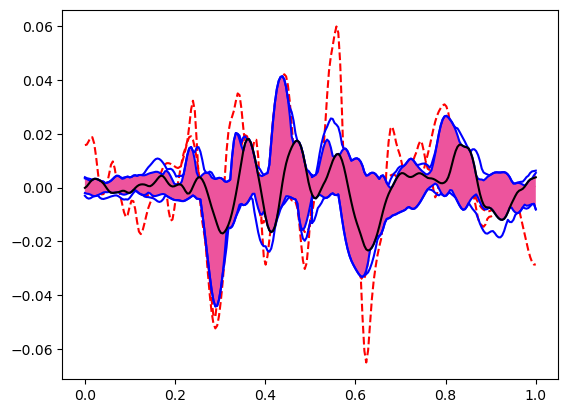

In [30]:
Boxplot(
    waves_fd,
    depth_method=ModifiedBandDepth(),
).plot()
plt.show()

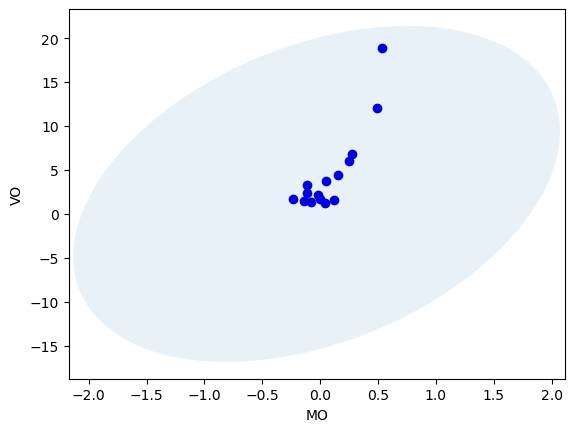

In [31]:
MagnitudeShapePlot(
    waves_fd,
).plot()
plt.show()

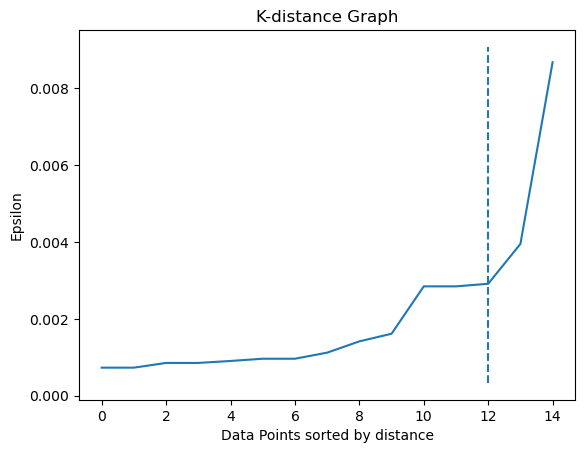

In [33]:
projection = fpca_discretized.transform(waves_fd)

# Get the projections of the first three components
first_component_projection = projection[:, 0]
second_component_projection = projection[:, 1]
#third_component_projection = projection[:, 2]

# Determine the optimal eps using K-distance Graph
nearest_neighbors = NearestNeighbors(n_neighbors=2)
neighbors = nearest_neighbors.fit(projection[:, :3])
distances, indices = neighbors.kneighbors(projection[:, :3])
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Use KneeLocator to find the elbow point
knee_locator = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
eps = distances[knee_locator.knee]

plt.figure()
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon')
plt.vlines(knee_locator.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

NameError: name 'third_component_projection' is not defined

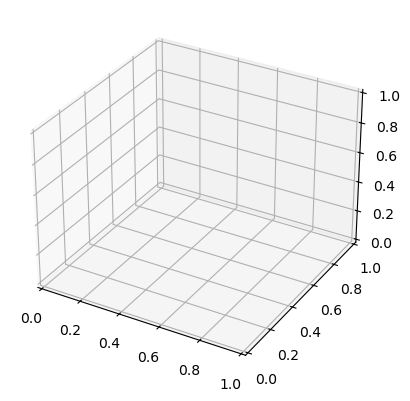

In [34]:
#Scatterplot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(first_component_projection, second_component_projection, third_component_projection)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=eps)
clusters = dbscan.fit_predict(projection[:, :3])

# Color the points based on the cluster they belong to
ax.scatter(first_component_projection, second_component_projection, third_component_projection, c=clusters)

# Add labels
for i, db_value in enumerate(db_values):
    ax.text(first_component_projection[i], second_component_projection[i], third_component_projection[i], str(db_value))

plt.title(f'{filename}: {frequency} Hz')
ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_zlabel('3rd PC')
plt.show()

In [35]:
import pandas as pd

# Create a DataFrame from the projection
df = pd.DataFrame(projection[:, :3], columns=['1st_PC', '2nd_PC', '3rd_PC'])

# Add the cluster assignments to the DataFrame
df['Cluster'] = clusters
# Add the db_values to the DataFrame
df['DB_Value'] = db_values

# Display the DataFrame
print(df)



ValueError: Shape of passed values is (15, 2), indices imply (15, 3)

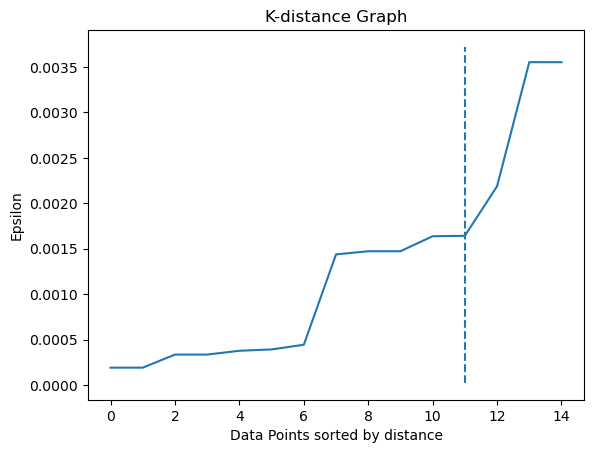

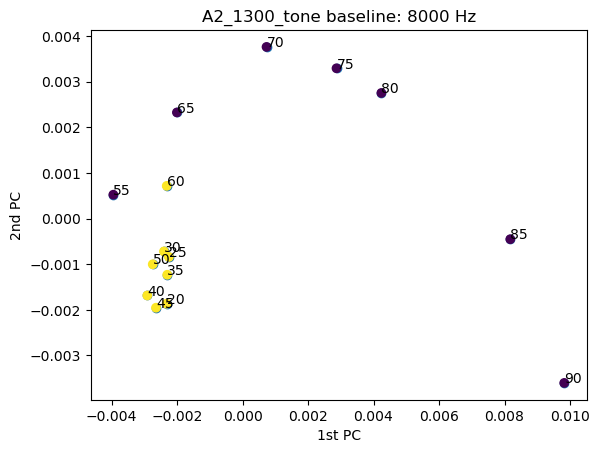

      1st_PC    2nd_PC  Cluster  DB_Value
0  -0.002320 -0.001866        0        20
1  -0.002251 -0.000842        0        25
2  -0.002400 -0.000721        0        30
3  -0.002301 -0.001232        0        35
4  -0.002910 -0.001685        0        40
5  -0.002644 -0.001954        0        45
6  -0.002744 -0.001003        0        50
7  -0.003948  0.000522       -1        55
8  -0.002316  0.000715        0        60
9  -0.002006  0.002323       -1        65
10  0.000731  0.003758       -1        70
11  0.002869  0.003290       -1        75
12  0.004239  0.002750       -1        80
13  0.008177 -0.000453       -1        85
14  0.009824 -0.003601       -1        90


In [58]:
# Importing necessary libraries
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator
import pandas as pd

# Transforming the data
projection = fpca_discretized.transform(waves_fd)

# Extracting the first two components of the projection
first_component_projection = projection[:, 0]
second_component_projection = projection[:, 1]

# Determining the optimal eps using K-distance Graph
nearest_neighbors = NearestNeighbors(n_neighbors=2)
neighbors = nearest_neighbors.fit(projection[:, :2])
distances, indices = neighbors.kneighbors(projection[:, :2])
distances = np.sort(distances, axis=0)
distances = distances[:,1]

knee_locator = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
eps = distances[knee_locator.knee]

# Plotting the K-distance Graph
plt.figure()
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon')
plt.vlines(knee_locator.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

# Creating a 2D scatter plot
plt.figure()
plt.scatter(first_component_projection, second_component_projection)

# Applying DBSCAN clustering
dbscan = DBSCAN(eps=eps)
clusters = dbscan.fit_predict(projection[:, :2])

# Coloring the points based on the cluster they belong to
plt.scatter(first_component_projection, second_component_projection, c=clusters)

# Adding labels to the points
for i, db_value in enumerate(db_values):
    plt.text(first_component_projection[i], second_component_projection[i], str(db_value))

# Finalizing the plot
plt.title(f'{filename}: {frequency} Hz')
plt.xlabel('1st PC')
plt.ylabel('2nd PC')
plt.show()

# Creating a DataFrame with each point and its corresponding cluster
df = pd.DataFrame(projection[:, :2], columns=['1st_PC', '2nd_PC'])
df['Cluster'] = clusters
df['DB_Value'] = db_values
print(df)


In [59]:
np.min(df[df['Cluster']==-1]['DB_Value'])

55